## To-do Functions:
- Read sto file.     x
- Read a directory with sto files     x
- Extract sequence and head.    x
- recognize different types of information from the file.     x
- Make graph.    x
- Create new text file and write seqs and the different relations into it.  x
- Create graphs with different type of information (user entry).    x
- Create target file. x
- 

In [1]:
%matplotlib inline
import os, sys
import subprocess as sp
from itertools import cycle
import networkx as nx
import re
import ntpath
import shutil
import fnmatch
from eden.util import display

read a Sto file separate the extract the interesting information from the file

it takes the file path and returns the head which is the information type and it's sequence

In [2]:
def _readStoFile(file_path =None):
    head_mark0 = '#'
    head_mark1 = '='
    head_mark2 = 'G'
    head_mark3 = 'C'
    head_list = []
    sequence_list = []  
    
    read_file = open(file_path ,'r') 
    for line in read_file: 
        lines = list(line)
            # the read line is the head of the sequence write it in head list
        if lines[0] == head_mark0 and lines[1] == head_mark1 and lines[2] == head_mark2 and lines[3] == head_mark3:
            line = line.strip('#=GC ')            
            line = line.strip('\n')
            line = line.split(' ')
            line = filter(None, line)

            head = line[0]
            head_list.append(head)
            sequence = line[1].split()
            sequence_list.append(sequence)
            zip_head_seqs = zip(head_list, sequence_list)
      
    return zip_head_seqs

recognize the different types of information extracted from step1
it takes the zipped info from the funtion '_readStoFile' and returns a dictionary 
    that identify every type of information

In [3]:
def _identifyInformationType(file_name, head_seq_list):

    secondery_structure_s = []
    conservation_s = []
    conservation_stringth_s = []
    entropy_0_s = []
    entropy_1_s = []
    entropy_2_s = []
    entropy_3_s = []
    coveriation_s = []

    for i, elemant in enumerate(head_seq_list):
        info_item = head_seq_list[i]
        
        if info_item[0] == 'SS_cons':
            secondery_structure_s.append(str(info_item[1]))
            
        if info_item[0] == 'cons':
            conservation_s.append(str(info_item[1]))
            
        if info_item[0] == 'conss':
            conservation_stringth_s.append(info_item[1])
            
        if info_item[0] == 'col_entropy_0':
            entropy_0_s.append(info_item[1])
            
        if info_item[0] == 'col_entropy_1':
            entropy_1_s.append(info_item[1])

        if info_item[0] == 'col_entropy_2':
            entropy_2_s.append(info_item[1])
            
        if info_item[0] == 'col_entropy_3':
            entropy_3_s.append(info_item[1])   
            
        if info_item[0] == 'cov_SS_cons':
            coveriation_s.append(info_item[1])
            
    file_dictionary = {"ID_file name": file_name, "conservation": conservation_s, "secondery_structure": secondery_structure_s,
                       "conservation_stringth": conservation_stringth_s, "entropy_3": entropy_3_s, "covariation": coveriation_s}
    return file_dictionary

In [4]:
def _filterInfo(info_type):
    sequence = info_type['conservation']
    structure = info_type['secondery_structure']
    conservation_stringth = info_type['conservation_stringth']
    covariation = info_type['covariation']
    entropy_3 = info_type['entropy_3']

    sequence = sequence[0].strip('[\']')
    #print ('seq', sequence)
    structure = structure[0].strip('[\']')
    #print ('stru', structure)
    conservation_stringth = str(conservation_stringth[0]).strip('[\']')
    covariation = str(covariation).strip('[\']')
    entropy_3 = str(entropy_3[0]).strip('[\']')

    zip_info_type = zip(sequence,conservation_stringth,covariation,entropy_3)
    return sequence, structure, conservation_stringth, covariation, entropy_3
    #return zip_info_type, structure

build a Networkx graph with all type of info (the most general graph)

this graph identifies the basepair relation beside the next relation between the nodes

transform the general graph to the wanted graph based on parameters passed by the '_graphParametersList' function

In [5]:

def _buildGraph(head, sequence, structure, conservation_stringth, covariation, entropy_3):
    
    print ("Graph title", head)
    open_pran = "<" or "(" or "[" or "{"
    close_pran = ">" or ")" or "]" or "}"
    stack_o = []
    stack_pos_o =[]
    stack_c = []

    G = nx.Graph()


    for i, k in enumerate(structure):
        
        #node labeled with all info
        seqCovConssEnt = sequence[i] + covariation[i] + conservation_stringth[i] + entropy_3[i]
        G.add_node(i, label = seqCovConssEnt)
        
        # connect with the next node 
        if i > 0:
            G.add_edge(i-1, i, label= 'x')
           
        """find basepair and connect them"""
        if structure[i] == open_pran:
            j = i
            stack_o.append(structure[j])
            stack_pos_o.append(j)
            open_len = len(stack_o)

        if structure[i] == close_pran:
            stack_c.append(structure[i])
            stack_o.pop()
            j = stack_pos_o.pop()
            G.add_edge(i, j, label = 'b')
    return G 

### Read one file

read one STO file, extract the desired info, and then build the graph

it takes the STO file path and returns it's graph

In [9]:
def _FileToGraphConvertor(file_path=None):
    head = ntpath.splitext(ntpath.basename(file_path))[0]
    zip_head_seqs = _readStoFile(file_path)
    #print zip_head_seqs
    info_type = _identifyInformationType(head, zip_head_seqs)
    sequence, structure, conservation_stringth, covariation, entropy_3 = _filterInfo(info_type)
    graph = _buildGraph(head, sequence, structure, conservation_stringth, covariation, entropy_3)
    return graph

### Read a directory

read a folder of STO files and then call '_FileToGraphWrapper' function

it taked the directory path and returns list of their's graphs

In [7]:
def _FolderToGraphConvertor(directory = None):
    graph_list = []
    for file_name in os.listdir(directory):
        file_complete_path = os.path.join(directory, file_name)
        graphs = _FileToGraphConvertor(file_complete_path)
        graph_list += [graphs.copy()]
    return graph_list

## Experiments:

#### read a single '.sto' file and create its graph

('Graph title', '550-53949-1-0')


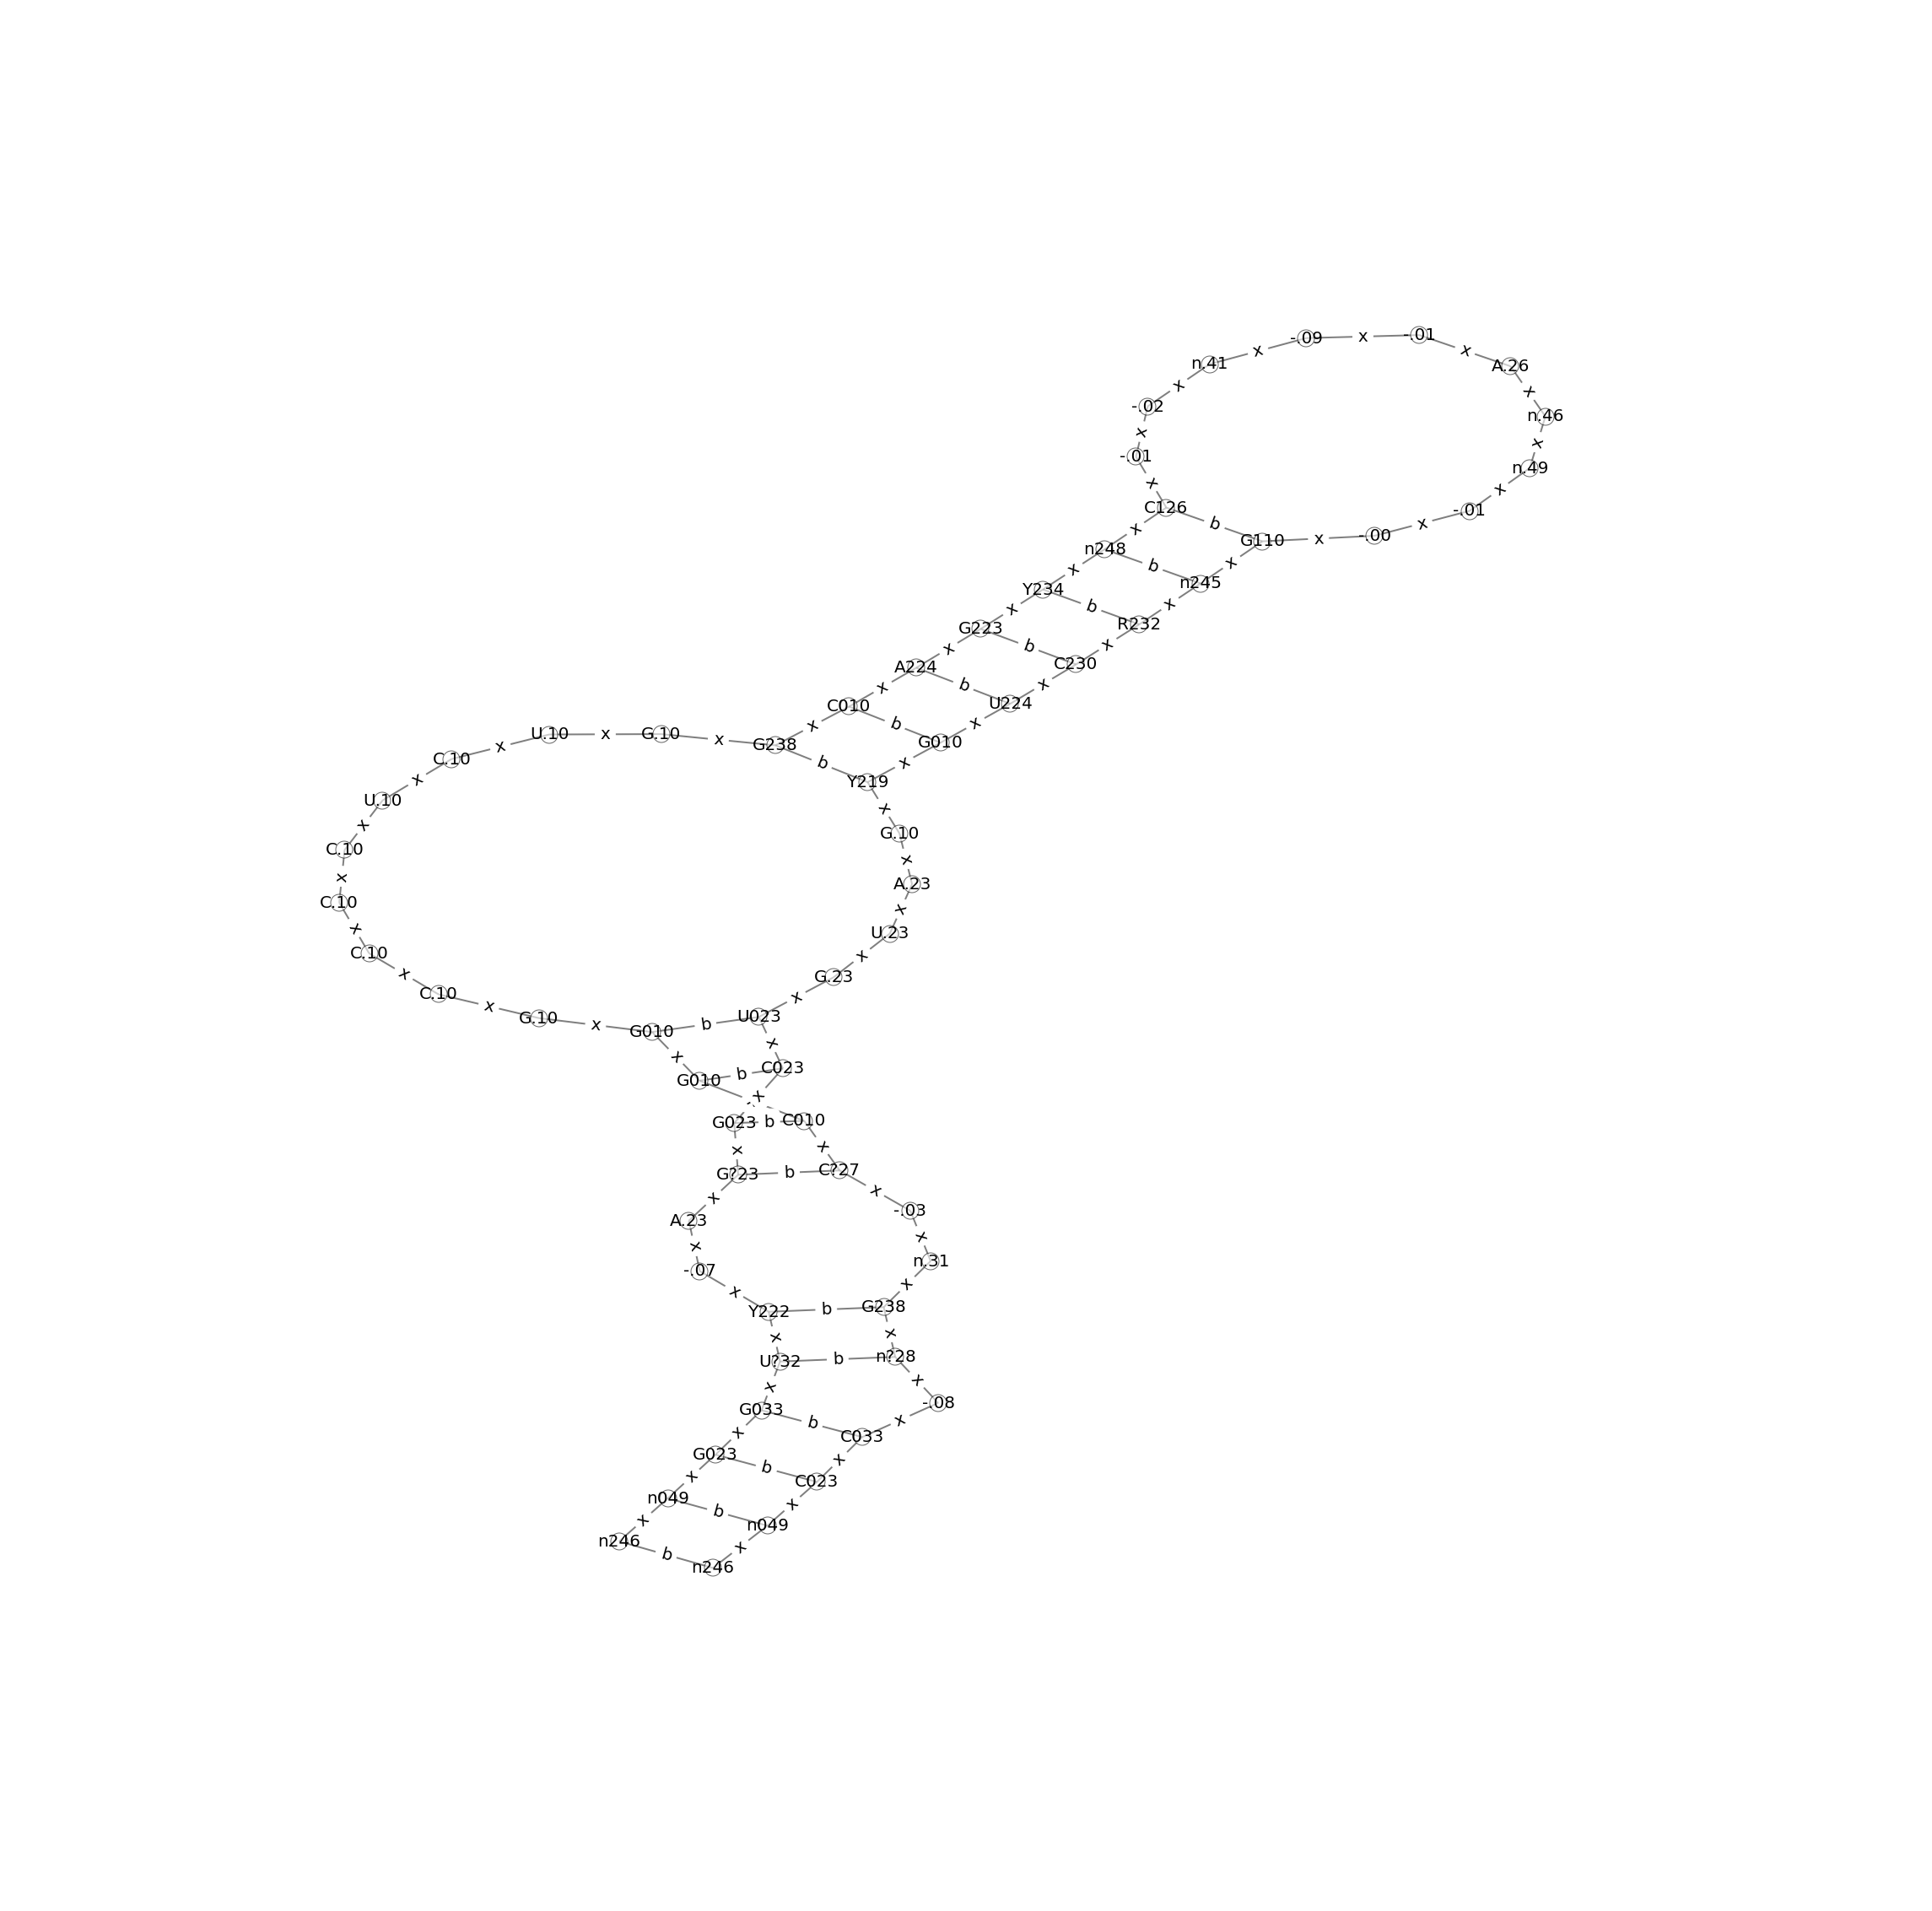

In [10]:
file_path = "StoExamples/StoExmapleSmall/positives-sto/550-53949-1-0.sto"
abs_path = os.path.abspath(file_path)
Graph = _FileToGraphConvertor(file_path)
display.draw_graph(Graph, size=40, node_size=400, font_size=20, node_border=True, prog='neato')

#### read a directory of '.sto' files and create their graphs

In [11]:
pos_dir = "StoExamples/StoExmapleSmall/positives-sto"
neg_dir = "StoExamples/StoExmapleSmall/negatives-sto"
pos_abs_path = os.path.abspath(pos_dir)
neg_abs_path = os.path.abspath(neg_dir)

pos_Graphs = _FolderToGraphConvertor(pos_abs_path)
neg_Graphs = _FolderToGraphConvertor(neg_abs_path)

('Graph title', '550-70730-0-0')
('Graph title', '550-53949-1-0')
('Graph title', '550-70852-0-0')
('Graph title', '550-69275-0-0')
('Graph title', '550-69410-0-0')
('Graph title', '550-904-1-0')
('Graph title', '550-1143-1-0')
('Graph title', '550-1153-0-0')
('Graph title', '550-751-0-0')
('Graph title', '550-1137-0-0')


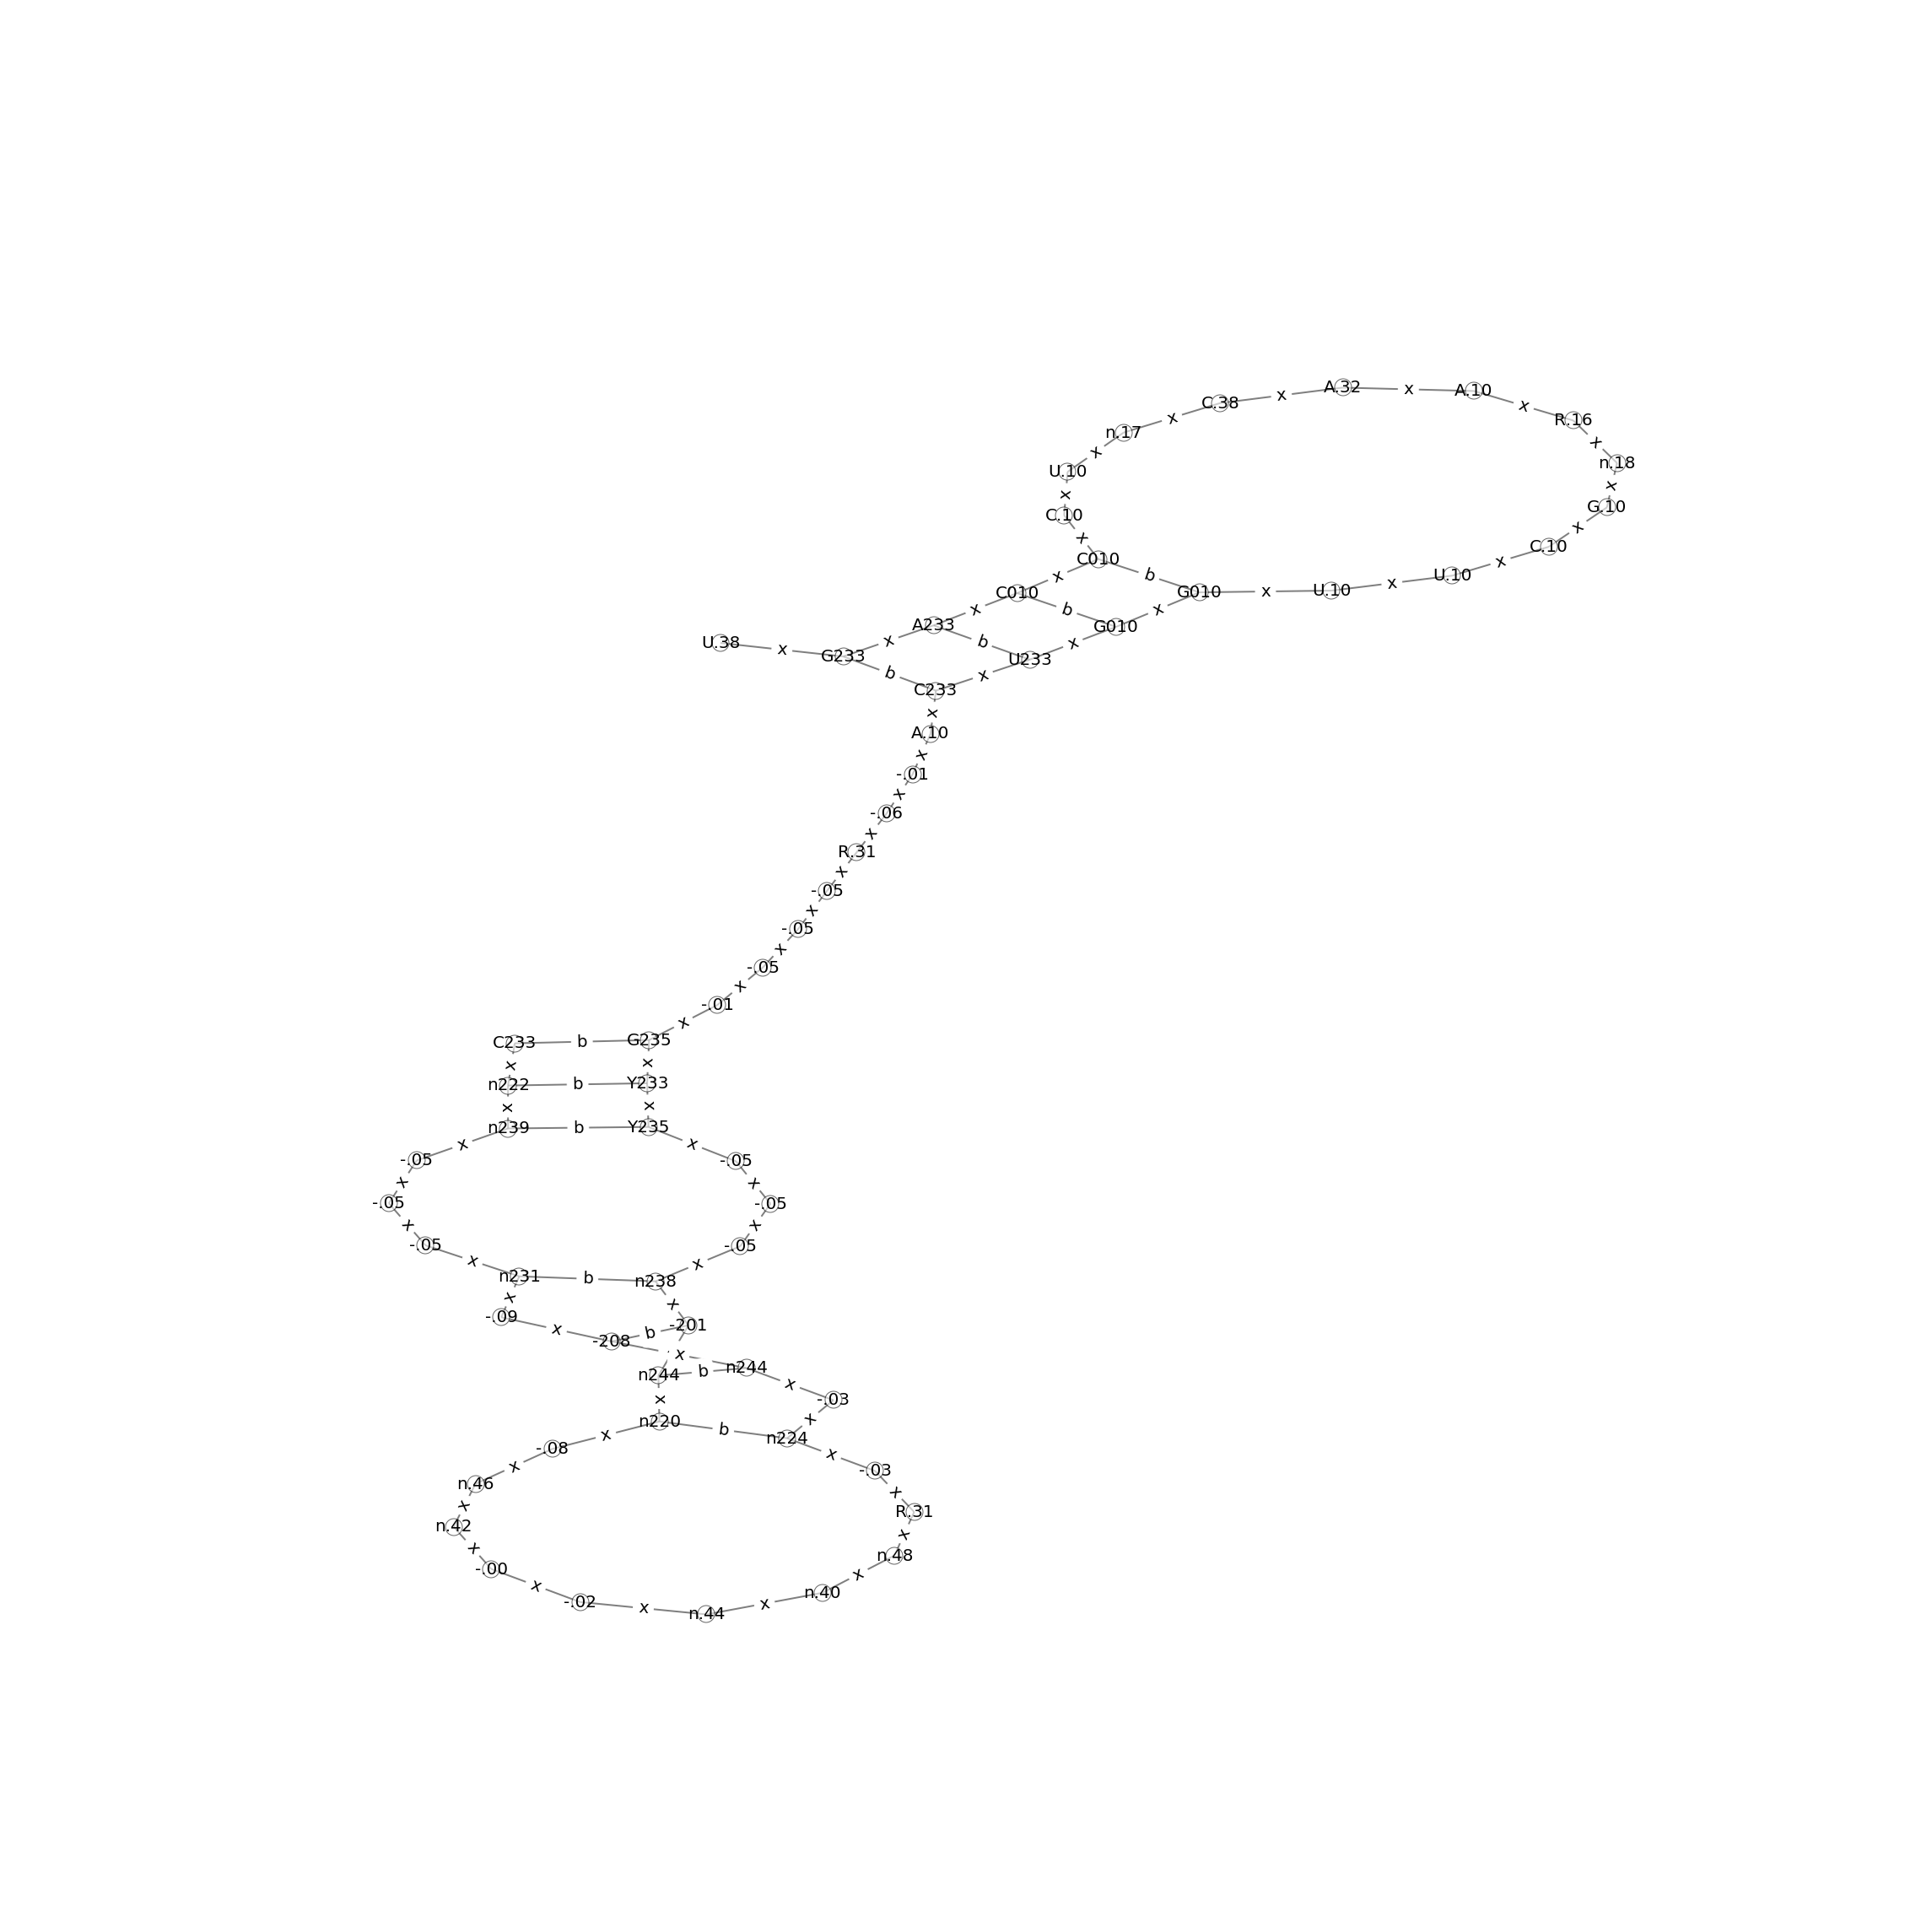

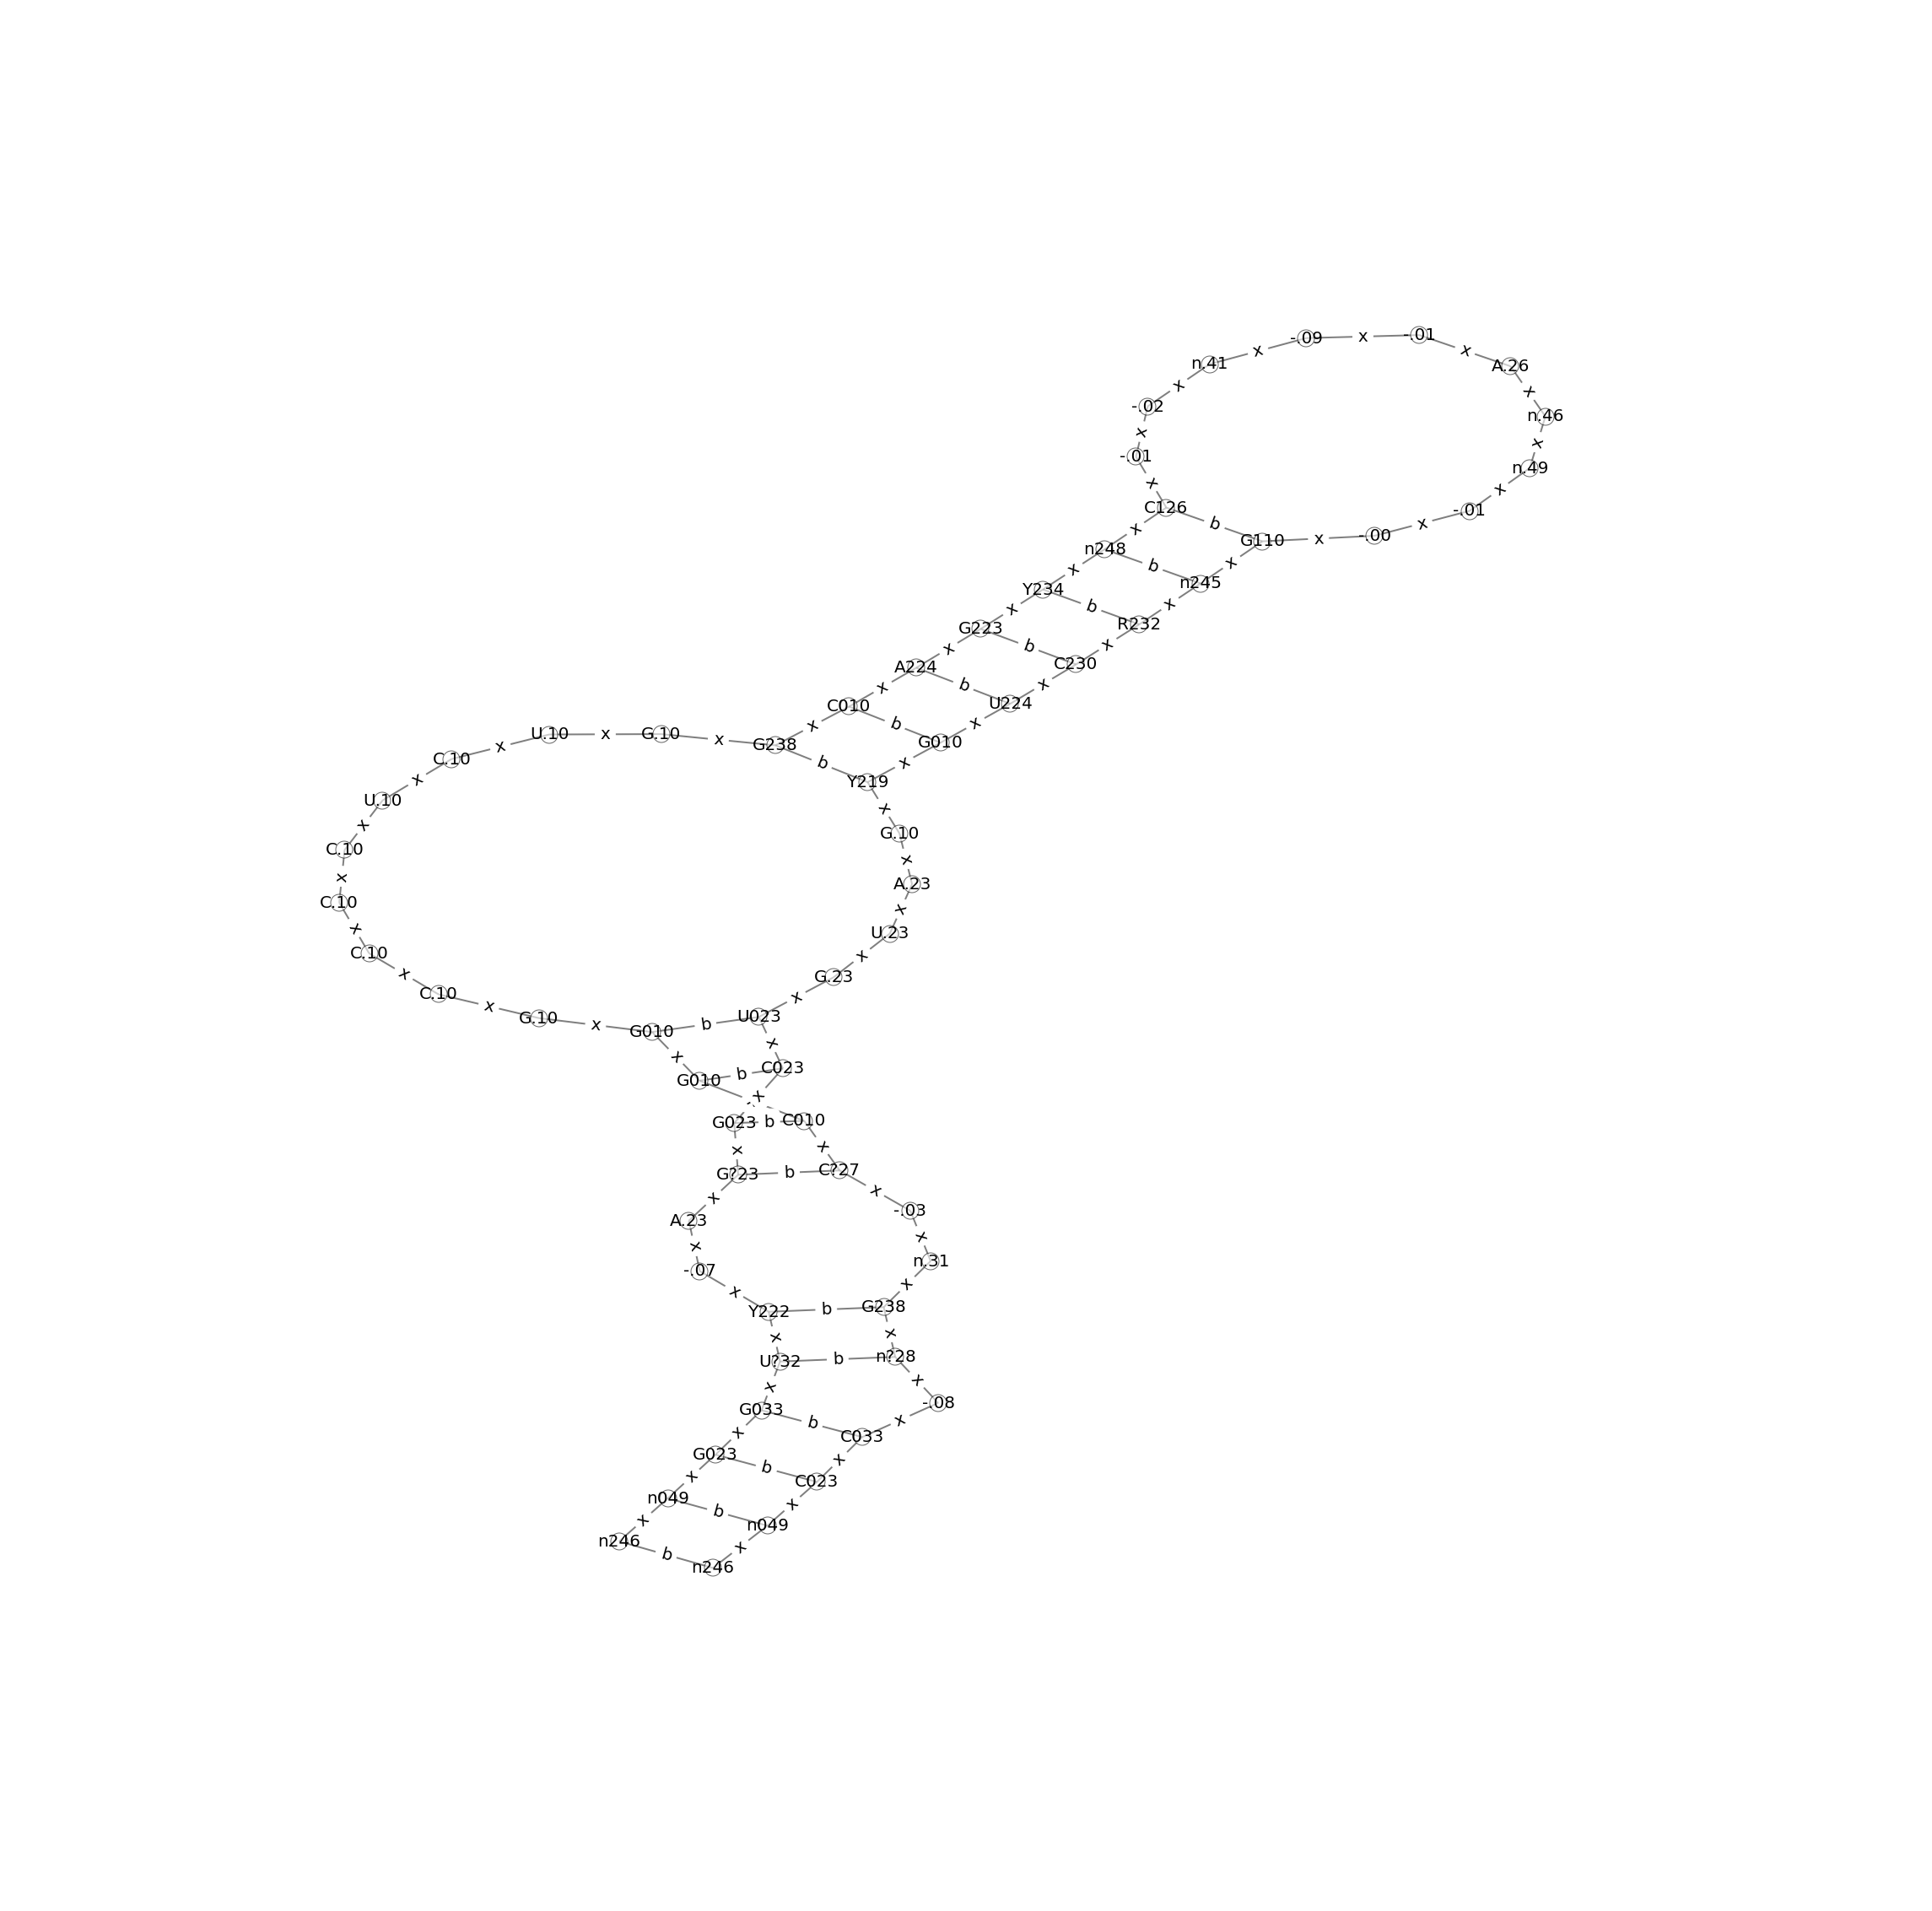

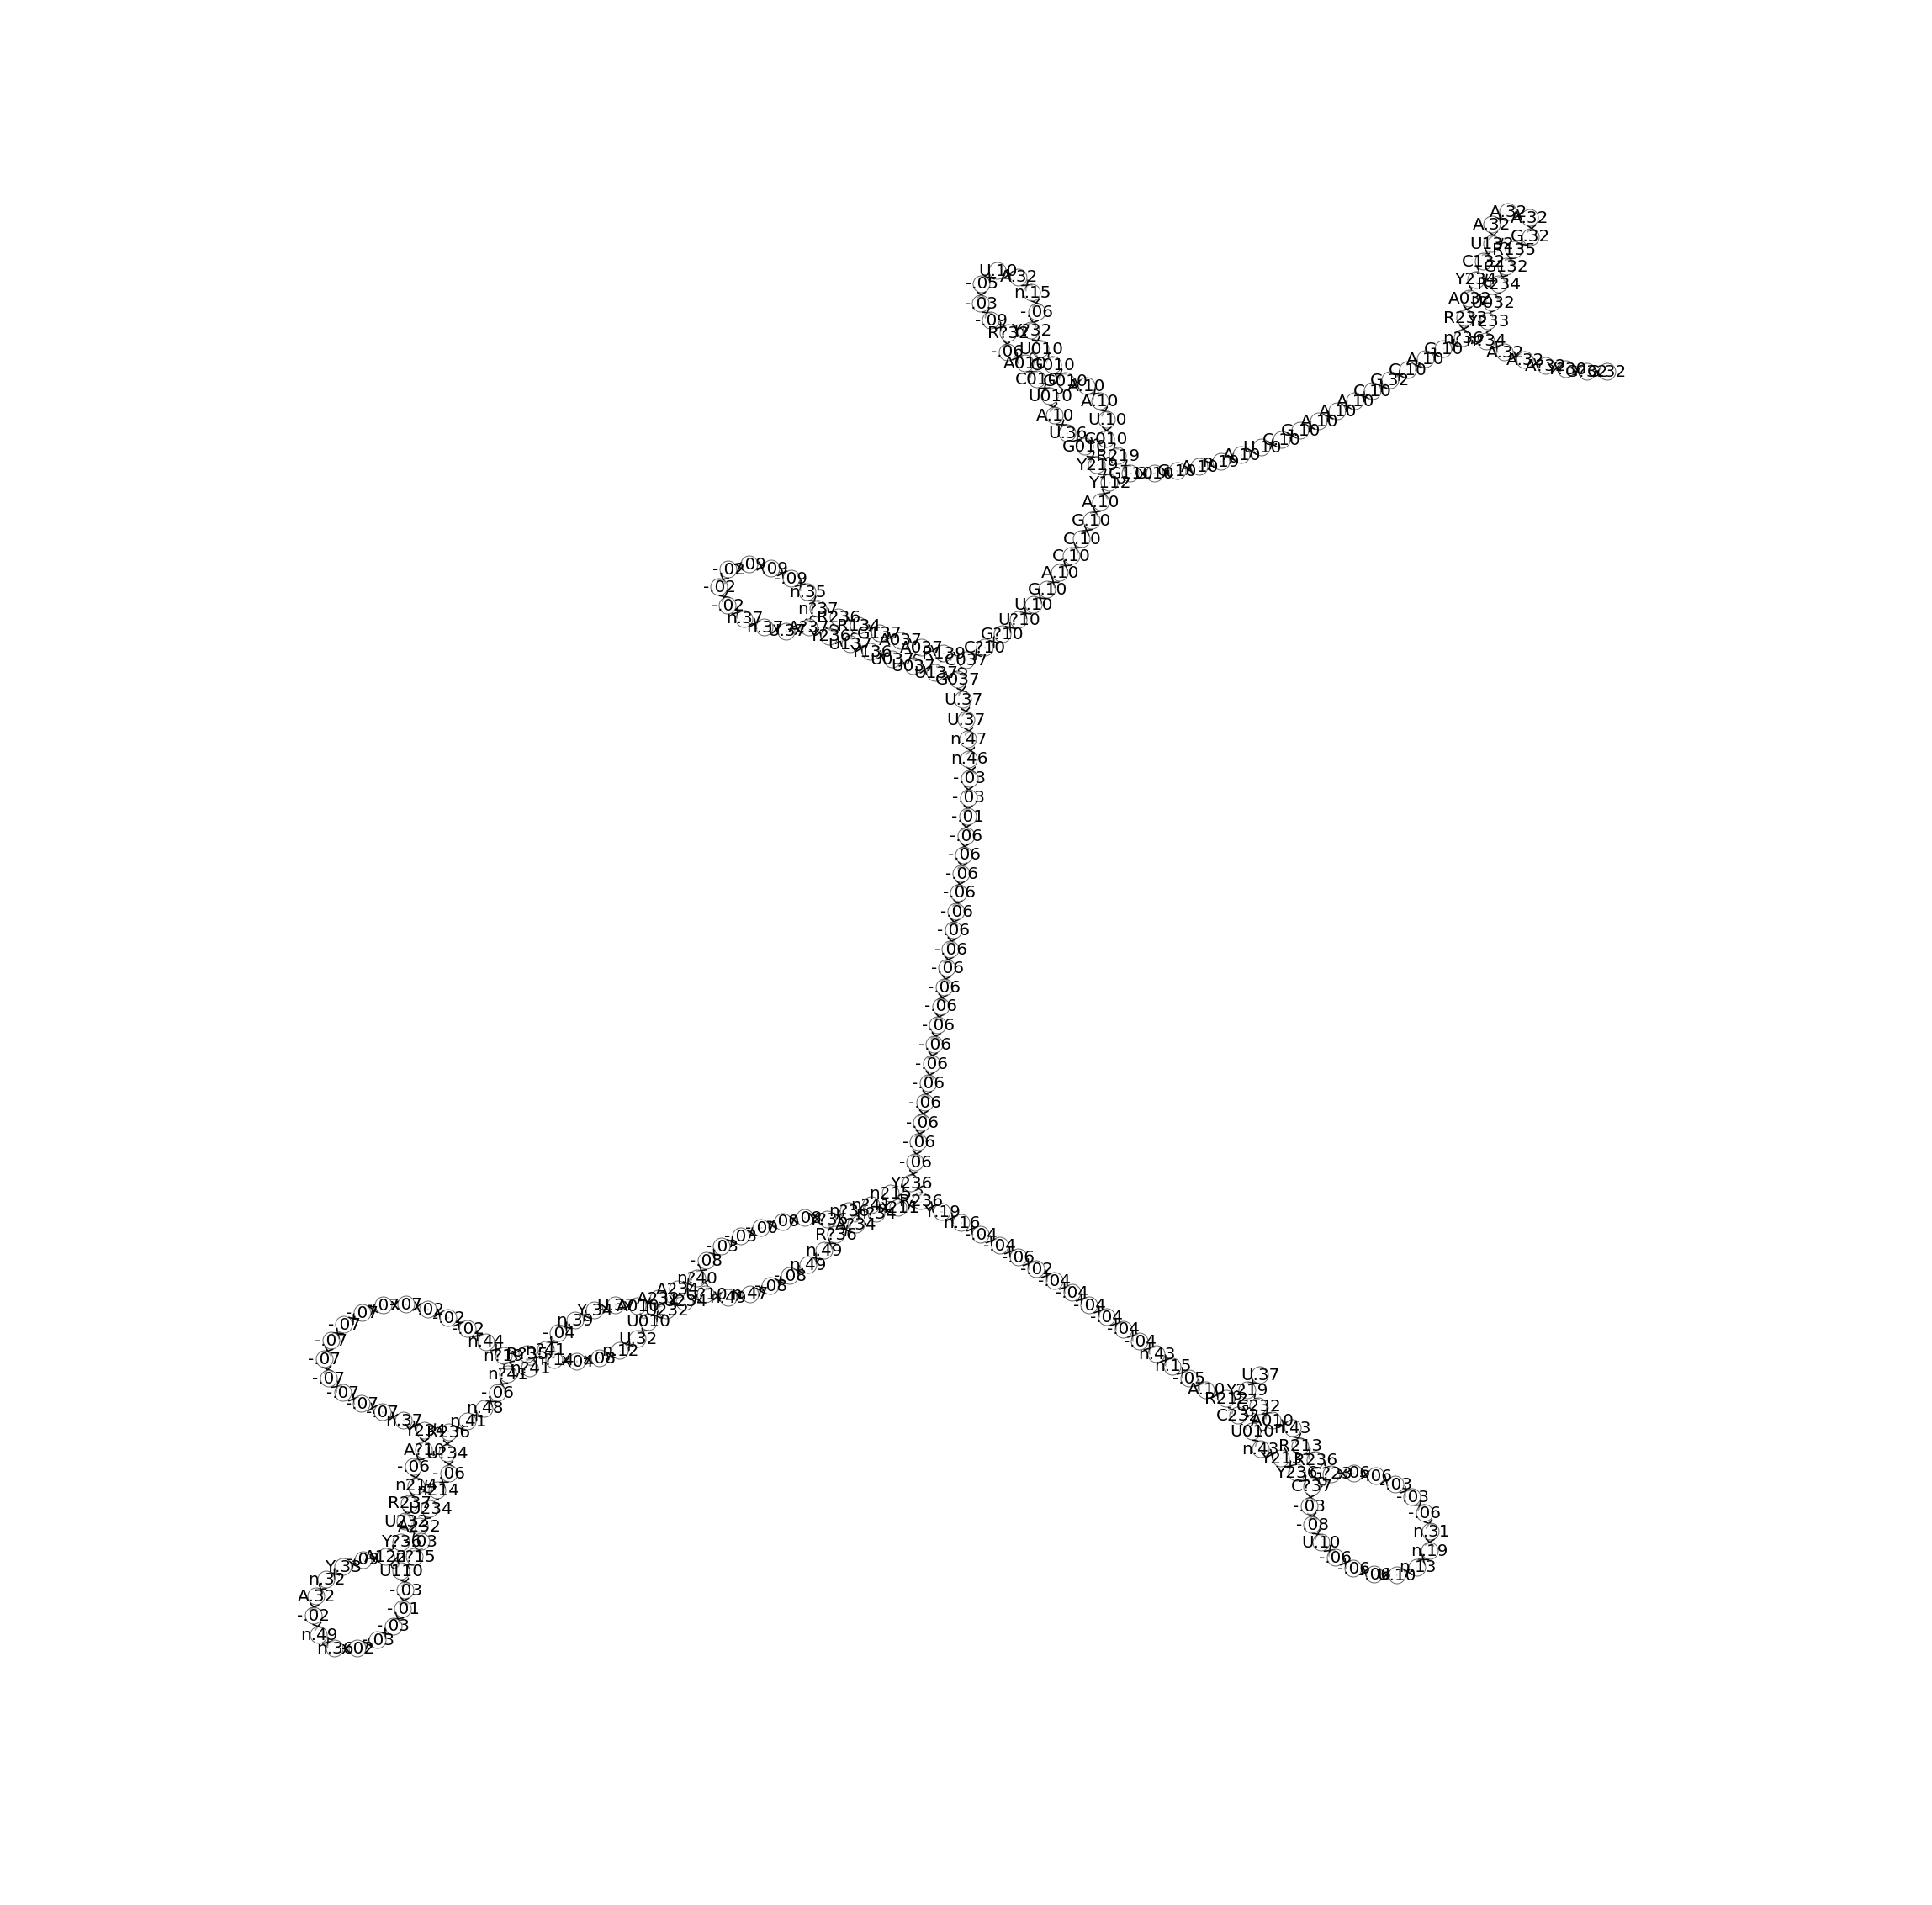

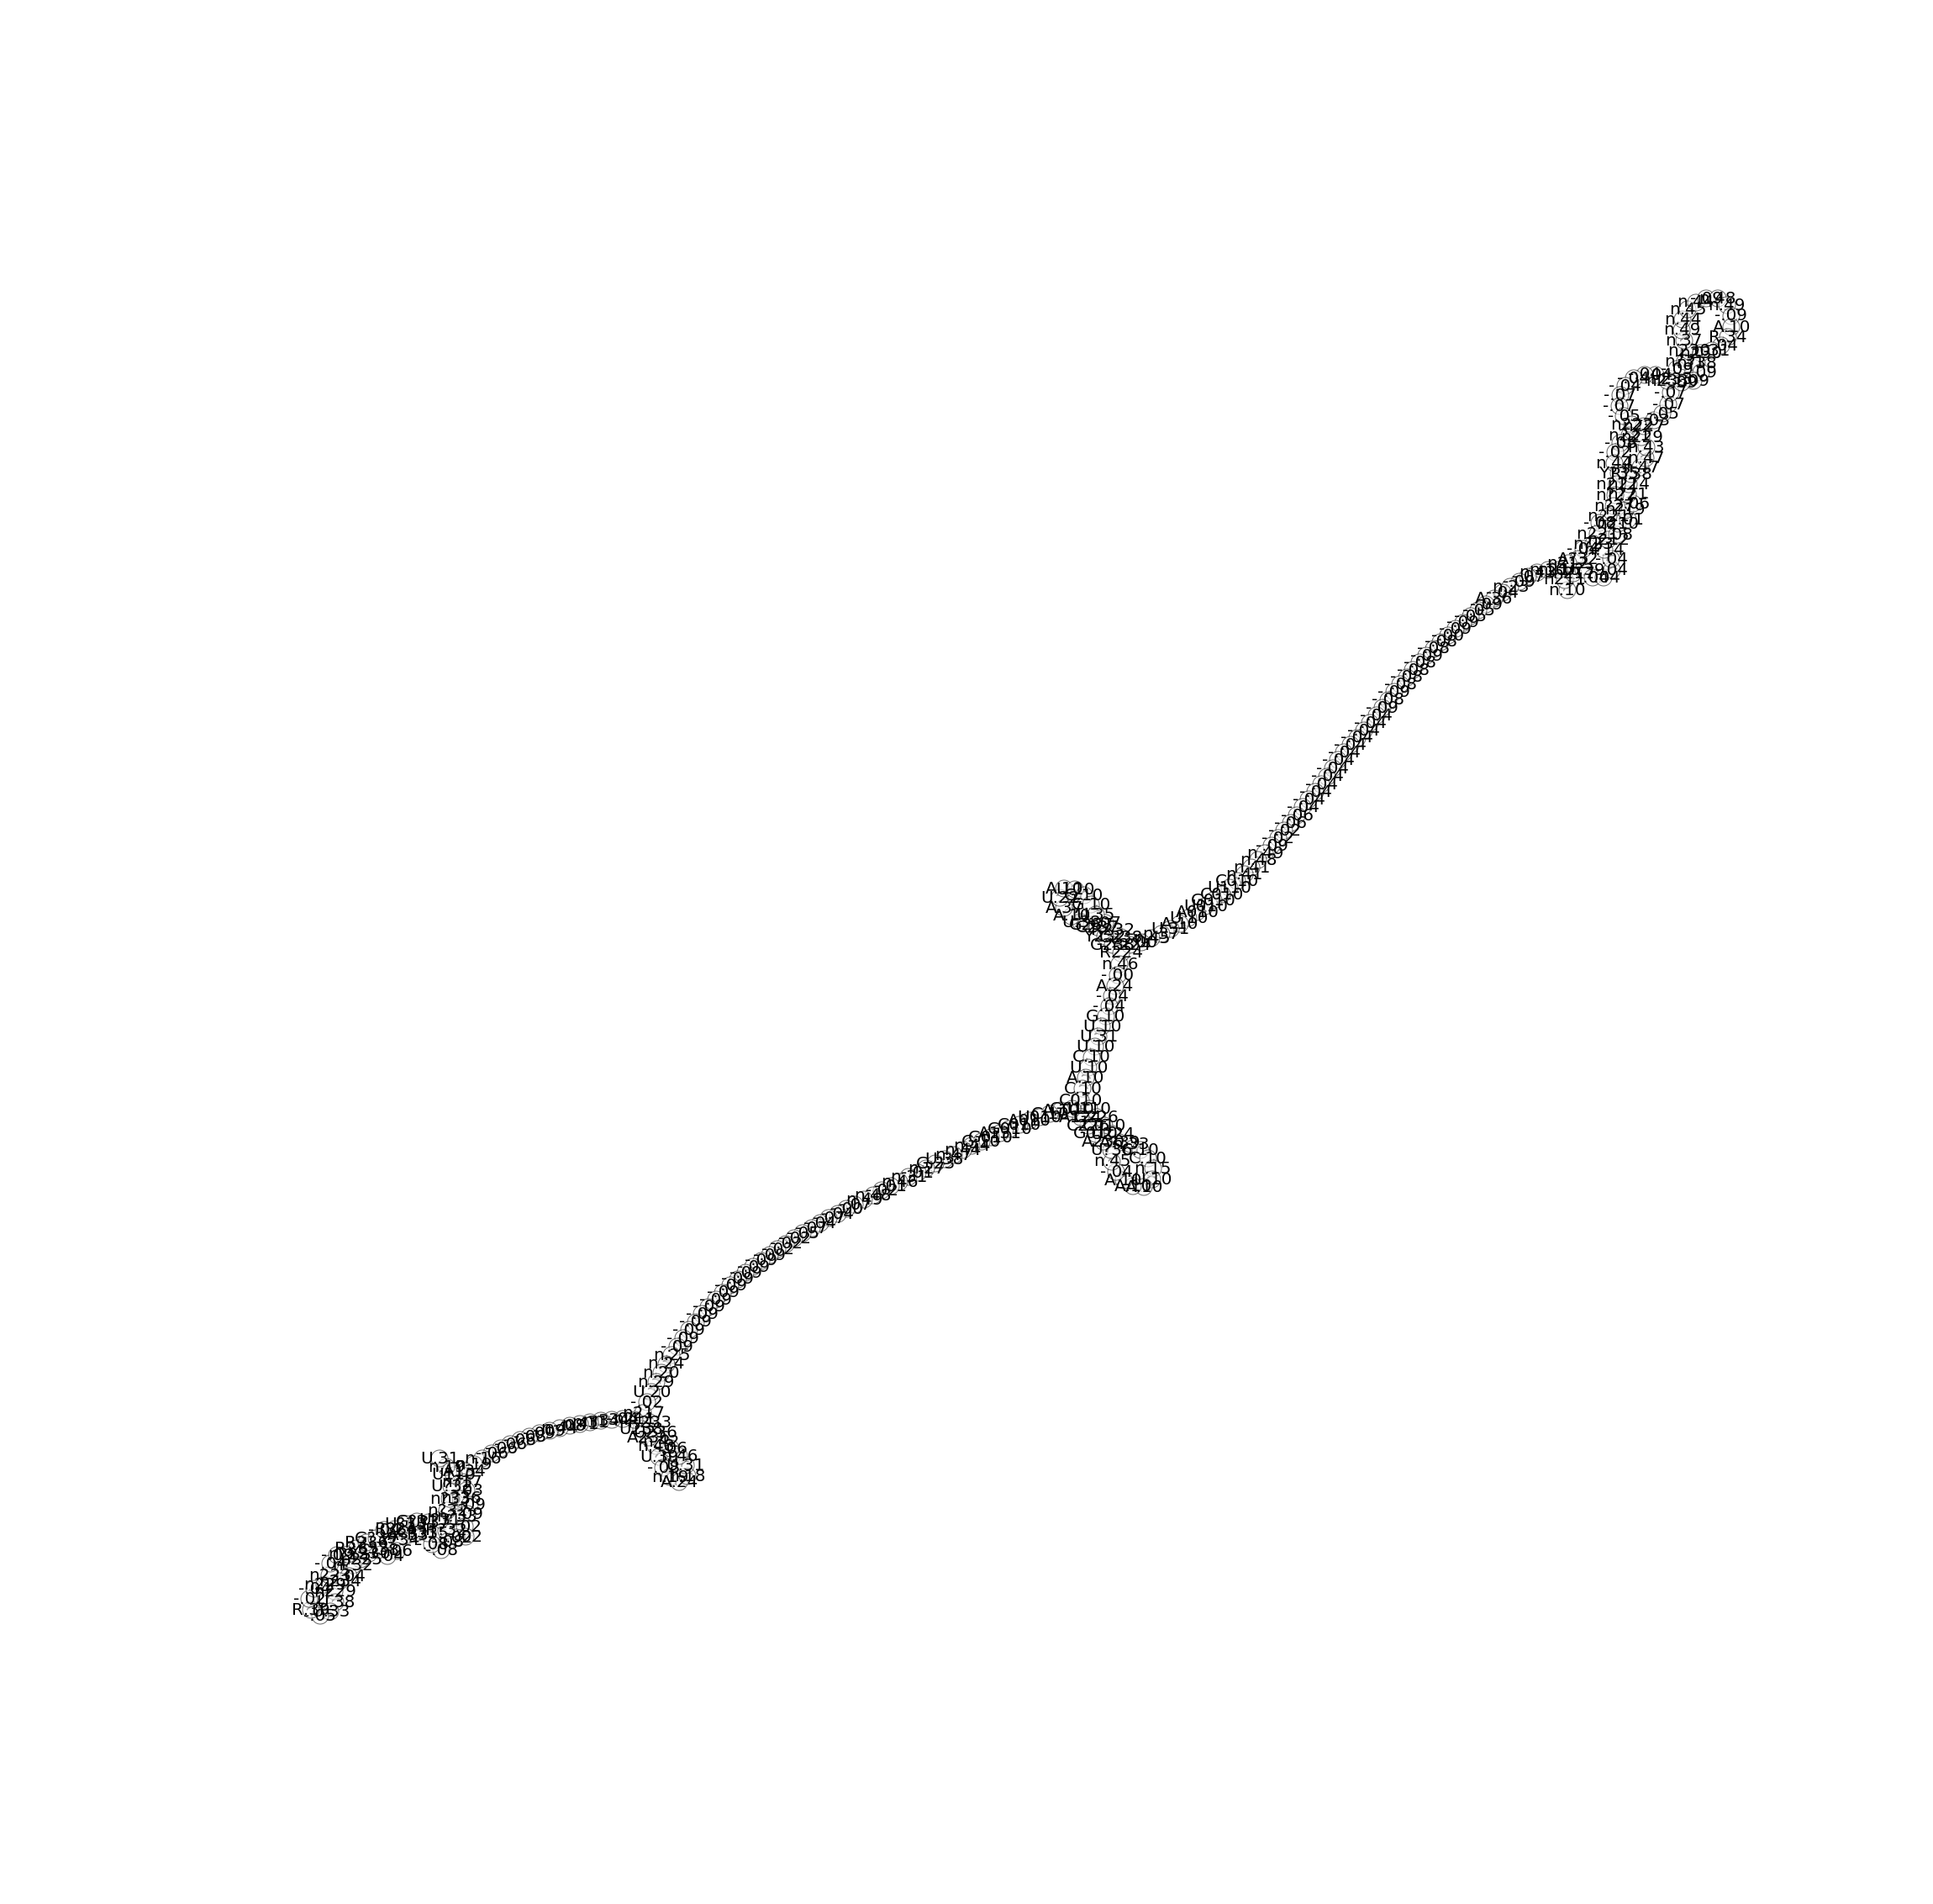

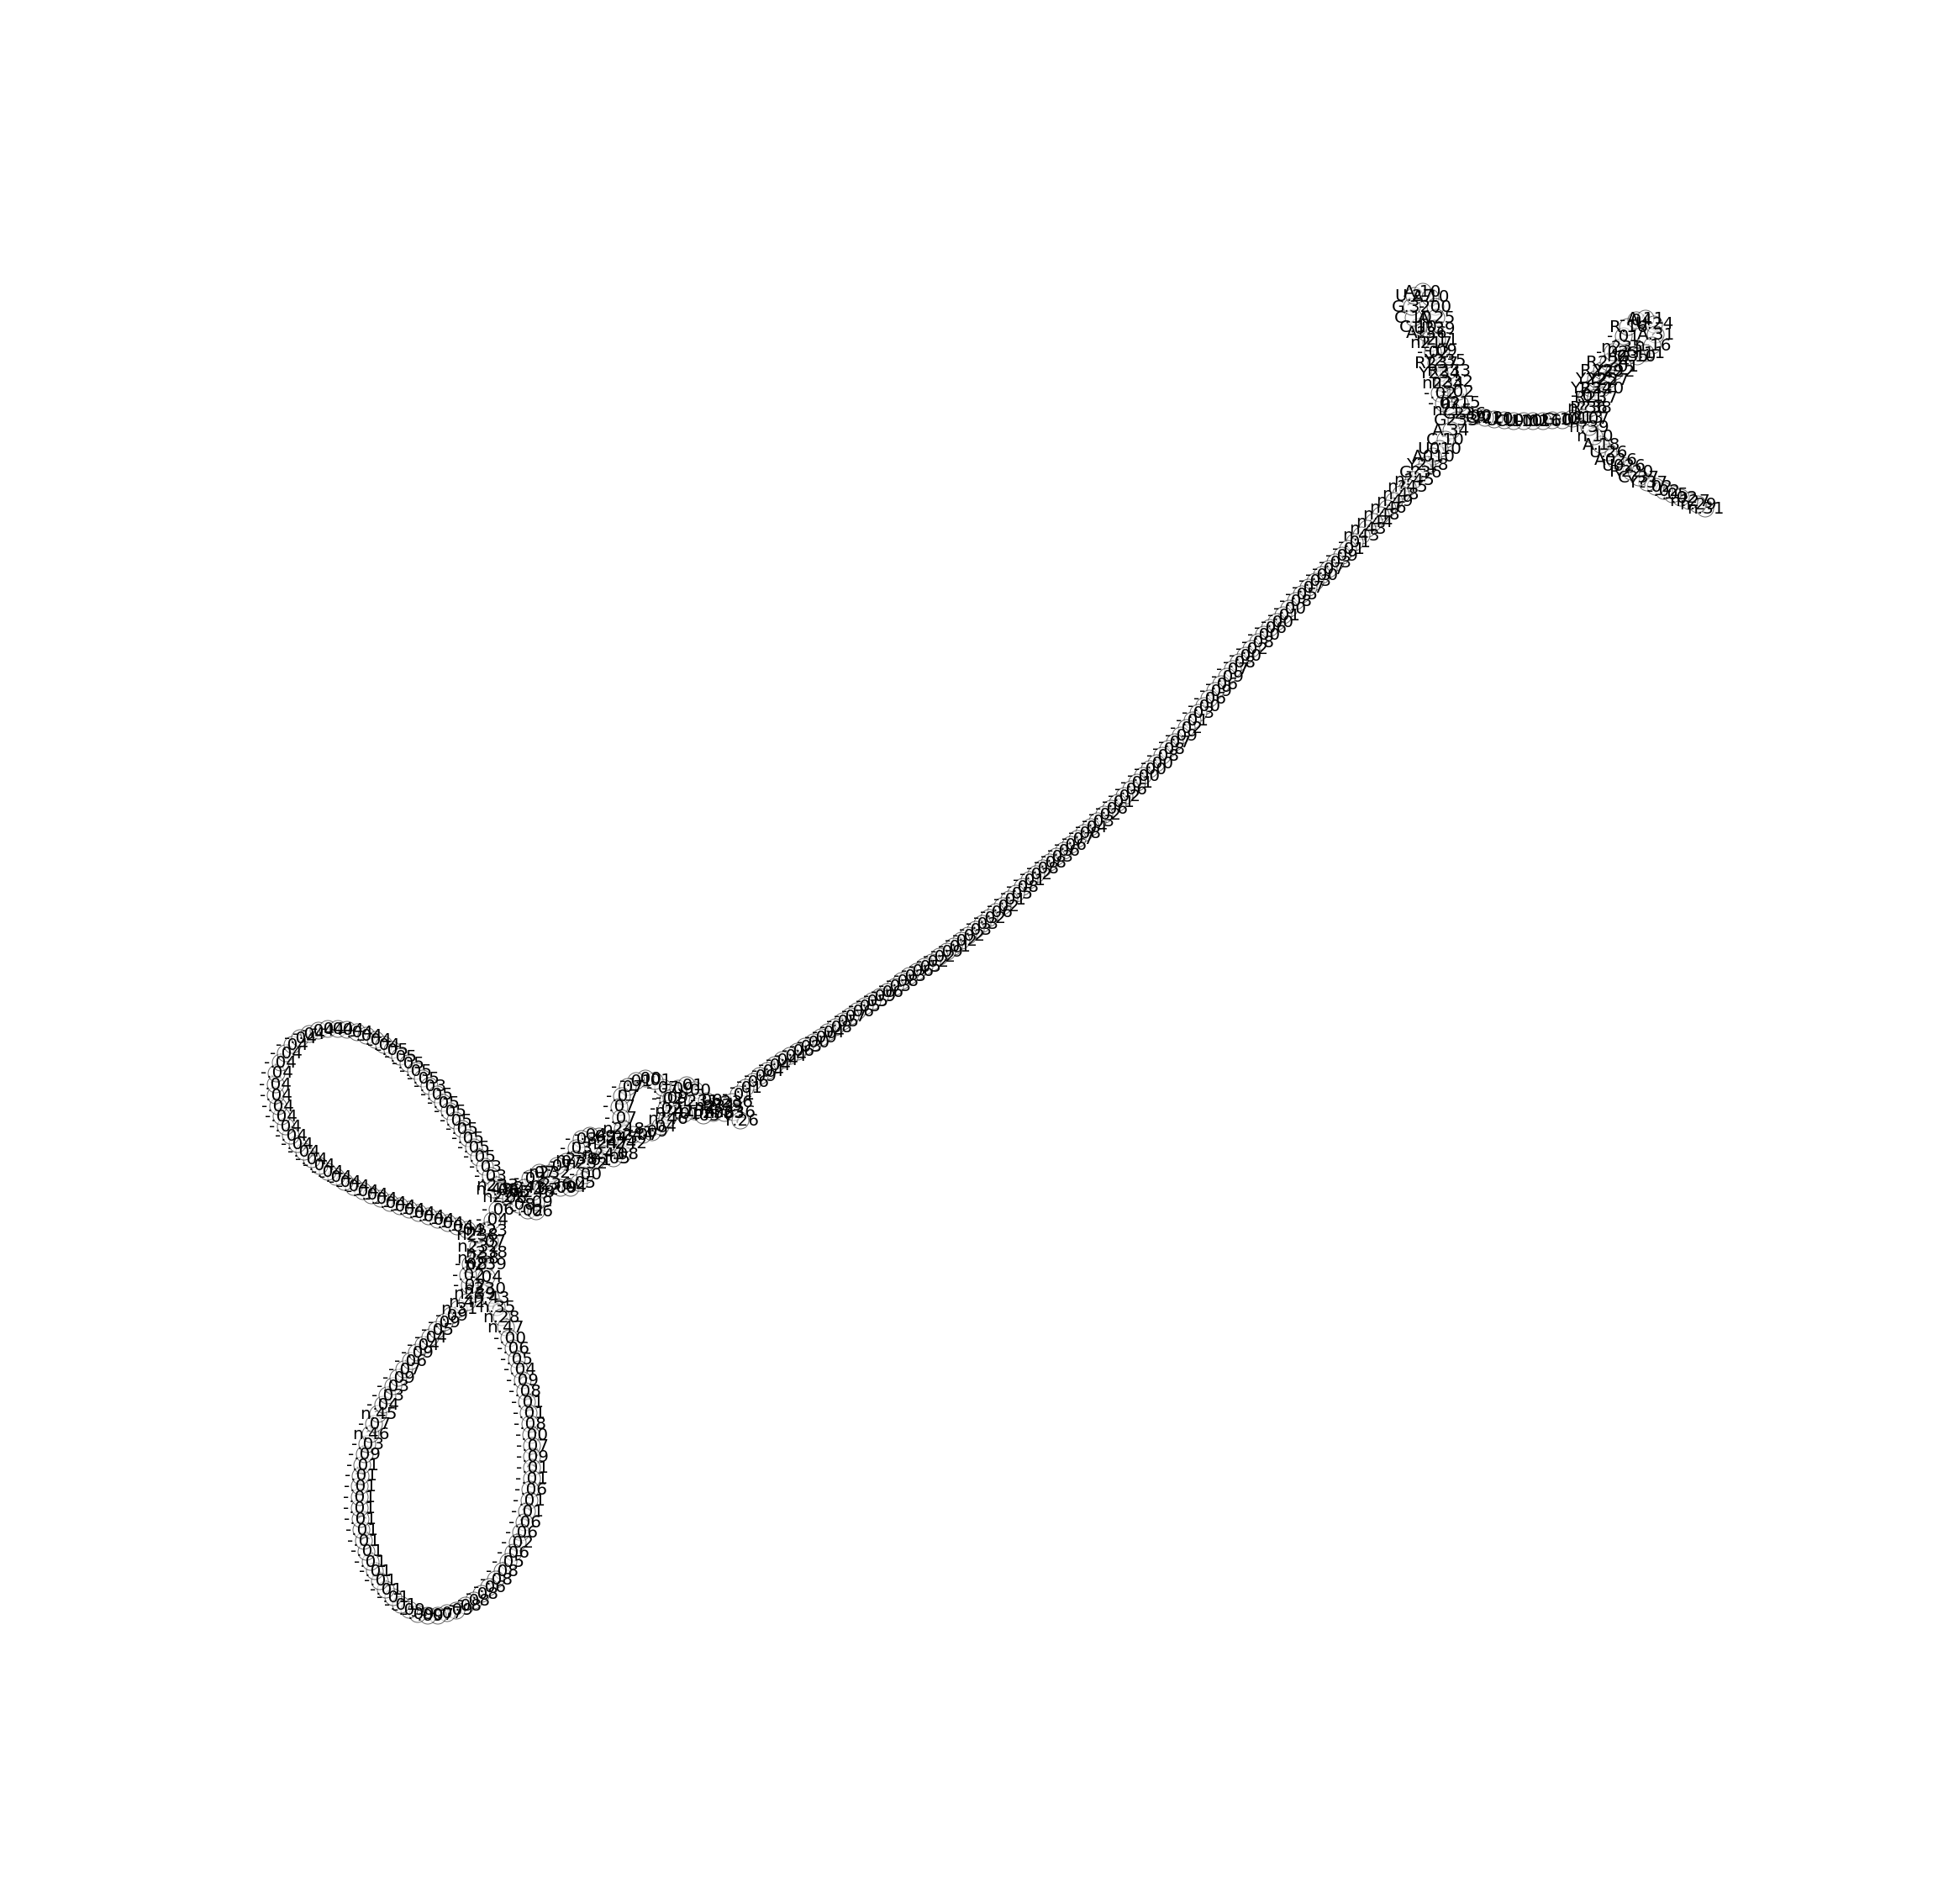

In [12]:
for G in pos_Graphs:
    display.draw_graph(G, size=40, node_size=400, font_size=20, node_border=True, prog='neato')

# Classification

In [13]:
import numpy as np
y = [1]*len(pos_Graphs) + [-1]*len(neg_Graphs)
y = np.asarray([int(value) for value in y])
print y
graphs = pos_Graphs + neg_Graphs

[ 1  1  1  1  1 -1 -1 -1 -1 -1]


In [14]:
from eden.converter.graph.gspan import gspan_to_eden
#graphs = gspan_to_eden('http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan')
graphs = pos_Graphs + neg_Graphs
#print graphs

In [15]:
from eden.graph import Vectorizer
vectorizer = Vectorizer(complexity=3)
#print vectorizer

In [16]:
%%time
X = vectorizer.transform(graphs)
print 'Instances: %d Features: %d with an avg of %d features per instance' % (X.shape[0], X.shape[1],  X.getnnz()/X.shape[0])

Instances: 10 Features: 1048577 with an avg of 2862 features per instance
CPU times: user 332 ms, sys: 36 ms, total: 368 ms
Wall time: 352 ms


In [17]:
%%time
#induce a predictive model
from sklearn.linear_model import SGDClassifier
predictor = SGDClassifier(average=True, class_weight='balanced', shuffle=True, n_jobs=-1)

from sklearn import cross_validation
scores = cross_validation.cross_val_score(predictor, X, y, cv=5, scoring='roc_auc')

import numpy as np
print('AUC ROC: %.4f +- %.4f' % (np.mean(scores),np.std(scores)))

AUC ROC: 0.8000 +- 0.4000
CPU times: user 372 ms, sys: 464 ms, total: 836 ms
Wall time: 470 ms


## Divide Sto files based on its classes:

In [ ]:
'''seperate classes into diffeerent folders'''

def _classesToFolders(files_dir, partition_dir, pos_class_0_path, pos_class_1_path, neg_class_0_path, neg_class_1_path):
    pos_partition_file = "positive-partitions-test.tab"
    neg_partition_file = "negative-partitions-test.tab"

    tab_list = os.listdir(partition_dir)
    for tab_file in os.listdir(partition_dir):
        files_list = os.listdir(files_dir)
        
        for folder_name in os.listdir(files_dir):
            folder_path = os.path.join(files_dir, folder_name)
            
            if tab_file == pos_partition_file and folder_name == 'positives-sto':
                read_pos_tab = open(os.path.join(partition_dir, tab_file), 'r')

                for line in read_pos_tab:
                    line_parts= line.split()
                    file_name = line_parts[0]
                    file_class_num = line_parts[1]

                    '''copy file to the pos_class_0 folder'''
                    if file_class_num == '0':
                        for file in os.listdir(folder_path):
                            file_path = os.path.join(folder_path, file)
                            file = ntpath.splitext( ntpath.basename(file_path))[0]
                            if fnmatch.fnmatch(file, file_name):
                                shutil.copy(file_path, pos_class_0_path)
                            
                    '''copy file to the pos_class_1 folder'''
                    if file_class_num == '1':                      
                        for file in os.listdir(folder_path):
                            file_path = os.path.join(folder_path, file)
                            file = ntpath.splitext( ntpath.basename(file_path))[0]
                            if fnmatch.fnmatch(file, file_name):
                                shutil.copy(file_path, pos_class_1_path)
                                
            if tab_file == neg_partition_file and folder_name == 'negatives-sto':
                read_neg_tab = open(os.path.join(partition_dir, tab_file), 'r')
                for line in read_neg_tab:
                    line_parts= line.split()
                    file_name = line_parts[0]
                    file_class_num = line_parts[1]
                    '''copy file to the pos_class_0 folder'''
                    if file_class_num == '0':
                        for file in os.listdir(folder_path):
                            file_path = os.path.join(folder_path, file)
                            file = ntpath.splitext( ntpath.basename(file_path))[0]
                            if fnmatch.fnmatch(file, file_name):
                                shutil.copy(file_path, neg_class_0_path)

                        '''copy file to the pos_class_1 folder'''
                    if file_class_num == '1':
                        for file in os.listdir(folder_path):
                            file_path = os.path.join(folder_path, file)
                            file = ntpath.splitext( ntpath.basename(file_path))[0]
                            if fnmatch.fnmatch(file, file_name):
                                shutil.copy(file_path, neg_class_1_path)

In [ ]:
files_dir = "StoExamples/StoExmapleSmall"
partition_dir = "StoExamples/partitionsFiles"

pos_class_0_path = "StoExamples/pos_class_0"
pos_class_1_path = "StoExamples/pos_class_1"
neg_class_0_path = "StoExamples/neg_class_0"
neg_class_1_path = "StoExamples/neg_class_1"

files_abs_path = os.path.abspath(files_dir)
partition_abs_path = os.path.abspath(partition_dir)
pos_class_0_abs_path = os.path.abspath(pos_class_0_path)
pos_class_1_abs_path = os.path.abspath(pos_class_1_path)
neg_class_0_abs_path = os.path.abspath(neg_class_0_path)
neg_class_1_abs_path = os.path.abspath(neg_class_1_path)


Class_to_folder = _classesToFolders(files_abs_path, partition_abs_path, pos_class_0_abs_path, pos_class_1_abs_path, neg_class_0_abs_path, neg_class_1_abs_path)


## Note: